# ⚠️ KRITISCHER HINWEIS: Datenqualitätsproblem entdeckt!

**Datum der Entdeckung:** 31. Januar 2026

## Problem

Die **SMARD API** liefert für **Filter-Code 1223** (dokumentiert als "Photovoltaik") **physikalisch falsche Daten**:
- Hohe Werte zur Nachtzeit (z.B. 3.676 MW um 23:00 Uhr im Januar)
- Steigender Trend über Nacht bis Mitternacht
- Winter-Werte höher als Sommer-Werte
- **Ergebnis:** Monatliche Saisonalität zeigt November > Mai (physikalisch unmöglich!)

## Lösung gefunden

**Filter-Code 4068** ("Solar generation actual") liefert **korrekte Solar-Daten**:
- Nacht-Werte nahe 0 MW ✅
- Peak zur Mittagszeit ✅
- Sommer höher als Winter ✅

## Status

✅ **Problem identifiziert**  
🔄 **Lösung:** Daten müssen mit Filter 4068 neu geladen werden  
📊 **Impact:** Alle Analysen in diesem Notebook basieren auf den FALSCHEN Daten

## Nächste Schritte

1. SMARD Loader anpassen (Filter 1223 → 4068)
2. Daten neu laden
3. Alle Notebooks aktualisieren
4. Modelle neu trainieren

---

# Explorative Datenanalyse - Energiedaten

**Ziel:** Erste Analyse der Energiedaten von SMARD (Bundesnetzagentur)

**Inhalte:**
1. Daten laden
2. Datenqualität prüfen
3. Grundlegende Visualisierungen
4. Statistische Eigenschaften
5. Saisonalität & Trends
6. Autokorrelation

In [2]:
# Standard imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Figure size
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 11

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 1. Daten laden

Wir nutzen die SMARD API der Bundesnetzagentur.

**Verfügbare Datenquellen:**
- `solar`: Photovoltaik-Erzeugung
- `wind_onshore`: Windkraft Onshore
- `wind_offshore`: Windkraft Offshore
- `consumption`: Stromverbrauch
- `price_day_ahead`: Day-Ahead Marktpreis
- `generation_total`: Gesamte Stromerzeugung
- Weitere siehe `src/data/smard_loader.py`

In [3]:
from data.smard_loader import load_smard_data, SMARDDataLoader

# Konfiguration
DATA_TYPE = 'solar'  # Ändere hier für andere Datenquellen
START_DATE = '2022-01-01'
END_DATE = '2024-12-31'
RESOLUTION = 'hour'

print(f"Lade {DATA_TYPE}-Daten von {START_DATE} bis {END_DATE}...\n")

Lade solar-Daten von 2022-01-01 bis 2024-12-31...



In [4]:
# Daten laden (wird gecached für schnelleres Nachladen)
df = load_smard_data(
    filter_name=DATA_TYPE,
    start_date=START_DATE,
    end_date=END_DATE,
    resolution=RESOLUTION,
    cache_dir=Path('../data/raw')
)

print(f"\n✅ Daten erfolgreich geladen: {len(df)} Datenpunkte")

Period: 2022-01-01 to 2024-12-31
  Requesting: https://www.smard.de/app/chart_data/4068/DE/4068_DE_hour_1641164400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4068/DE/4068_DE_hour_1641769200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4068/DE/4068_DE_hour_1642374000000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4068/DE/4068_DE_hour_1642978800000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4068/DE/4068_DE_hour_1643583600000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4068/DE/4068_DE_hour_1644188400000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4068/DE/4068_DE_hour_1644793200000.json
    Downloaded 168 records
  Requesting: https://www.smard.de/app/chart_data/4068/DE/4068_DE_hour_1645398000000.json
    Downloaded 168 records
  Requesting: https://www.smard

In [5]:
# Erste Inspektion
print("Erste 5 Zeilen:")
display(df.head())

print("\nLetzte 5 Zeilen:")
display(df.tail())

print("\nDatentypen:")
print(df.dtypes)

print(f"\nZeitraum: {df['timestamp'].min()} bis {df['timestamp'].max()}")
print(f"Anzahl Tage: {(df['timestamp'].max() - df['timestamp'].min()).days}")

Erste 5 Zeilen:


,timestamp,value
0,2022-01-02 23:00:00,2.0
1,2022-01-03 00:00:00,2.0
2,2022-01-03 01:00:00,2.0
3,2022-01-03 02:00:00,2.0
4,2022-01-03 03:00:00,2.0



Letzte 5 Zeilen:


,timestamp,value
26252,2024-12-31 19:00:00,6.75
26253,2024-12-31 20:00:00,6.50
26254,2024-12-31 21:00:00,7.00
26255,2024-12-31 22:00:00,6.50
26256,2024-12-31 23:00:00,9.50



Datentypen:
timestamp    datetime64[ms]
value               float64
dtype: object

Zeitraum: 2022-01-02 23:00:00 bis 2024-12-31 23:00:00
Anzahl Tage: 1094


## 2. Datenqualität

Überprüfung auf:
- Fehlende Werte
- Duplikate
- Ausreißer
- Zeitlücken

In [10]:
print("=" * 60)
print("DATENQUALITÄTS-REPORT")
print("=" * 60)

# Fehlende Werte
missing = df['value'].isna().sum()
missing_pct = missing / len(df) * 100
print(f"\n1. Fehlende Werte: {missing} ({missing_pct:.2f}%)")

# Duplikate
duplicates = df.duplicated(subset=['timestamp']).sum()
print(f"\n2. Duplikate (Timestamp): {duplicates}")

# Zeitlücken prüfen
df_sorted = df.sort_values('timestamp').reset_index(drop=True)
time_diffs = df_sorted['timestamp'].diff()

if RESOLUTION == 'hour':
    expected_diff = pd.Timedelta(hours=1)
elif RESOLUTION == 'day':
    expected_diff = pd.Timedelta(days=1)
else:
    expected_diff = None

if expected_diff:
    gaps = time_diffs[time_diffs > expected_diff]
    print(f"\n3. Zeitlücken (> {expected_diff}): {len(gaps)}")
    if len(gaps) > 0:
        print("   Erste 5 Lücken:")
        for idx in gaps.head().index:
            print(f"     {df_sorted.loc[idx-1, 'timestamp']} -> {df_sorted.loc[idx, 'timestamp']}")

# Statistik
print(f"\n4. Wertebereich:")
print(f"   Min: {df['value'].min():,.0f}")
print(f"   Max: {df['value'].max():,.0f}")
print(f"   Mean: {df['value'].mean():,.0f}")
print(f"   Median: {df['value'].median():,.0f}")
print(f"   Std: {df['value'].std():,.0f}")

# Nullwerte
zeros = (df['value'] == 0).sum()
zeros_pct = zeros / len(df) * 100
print(f"\n5. Nullwerte: {zeros} ({zeros_pct:.2f}%)")

# Negative Werte
negatives = (df['value'] < 0).sum()
print(f"\n6. Negative Werte: {negatives}")

print("\n" + "=" * 60)

DATENQUALITÄTS-REPORT

1. Fehlende Werte: 0 (0.00%)

2. Duplikate (Timestamp): 0

3. Zeitlücken (> 0 days 01:00:00): 0

4. Wertebereich:
   Min: 1
   Max: 46,898
   Mean: 6,641
   Median: 193
   Std: 10,189

5. Nullwerte: 0 (0.00%)

6. Negative Werte: 0



## 3. Visualisierung - Gesamtzeitreihe

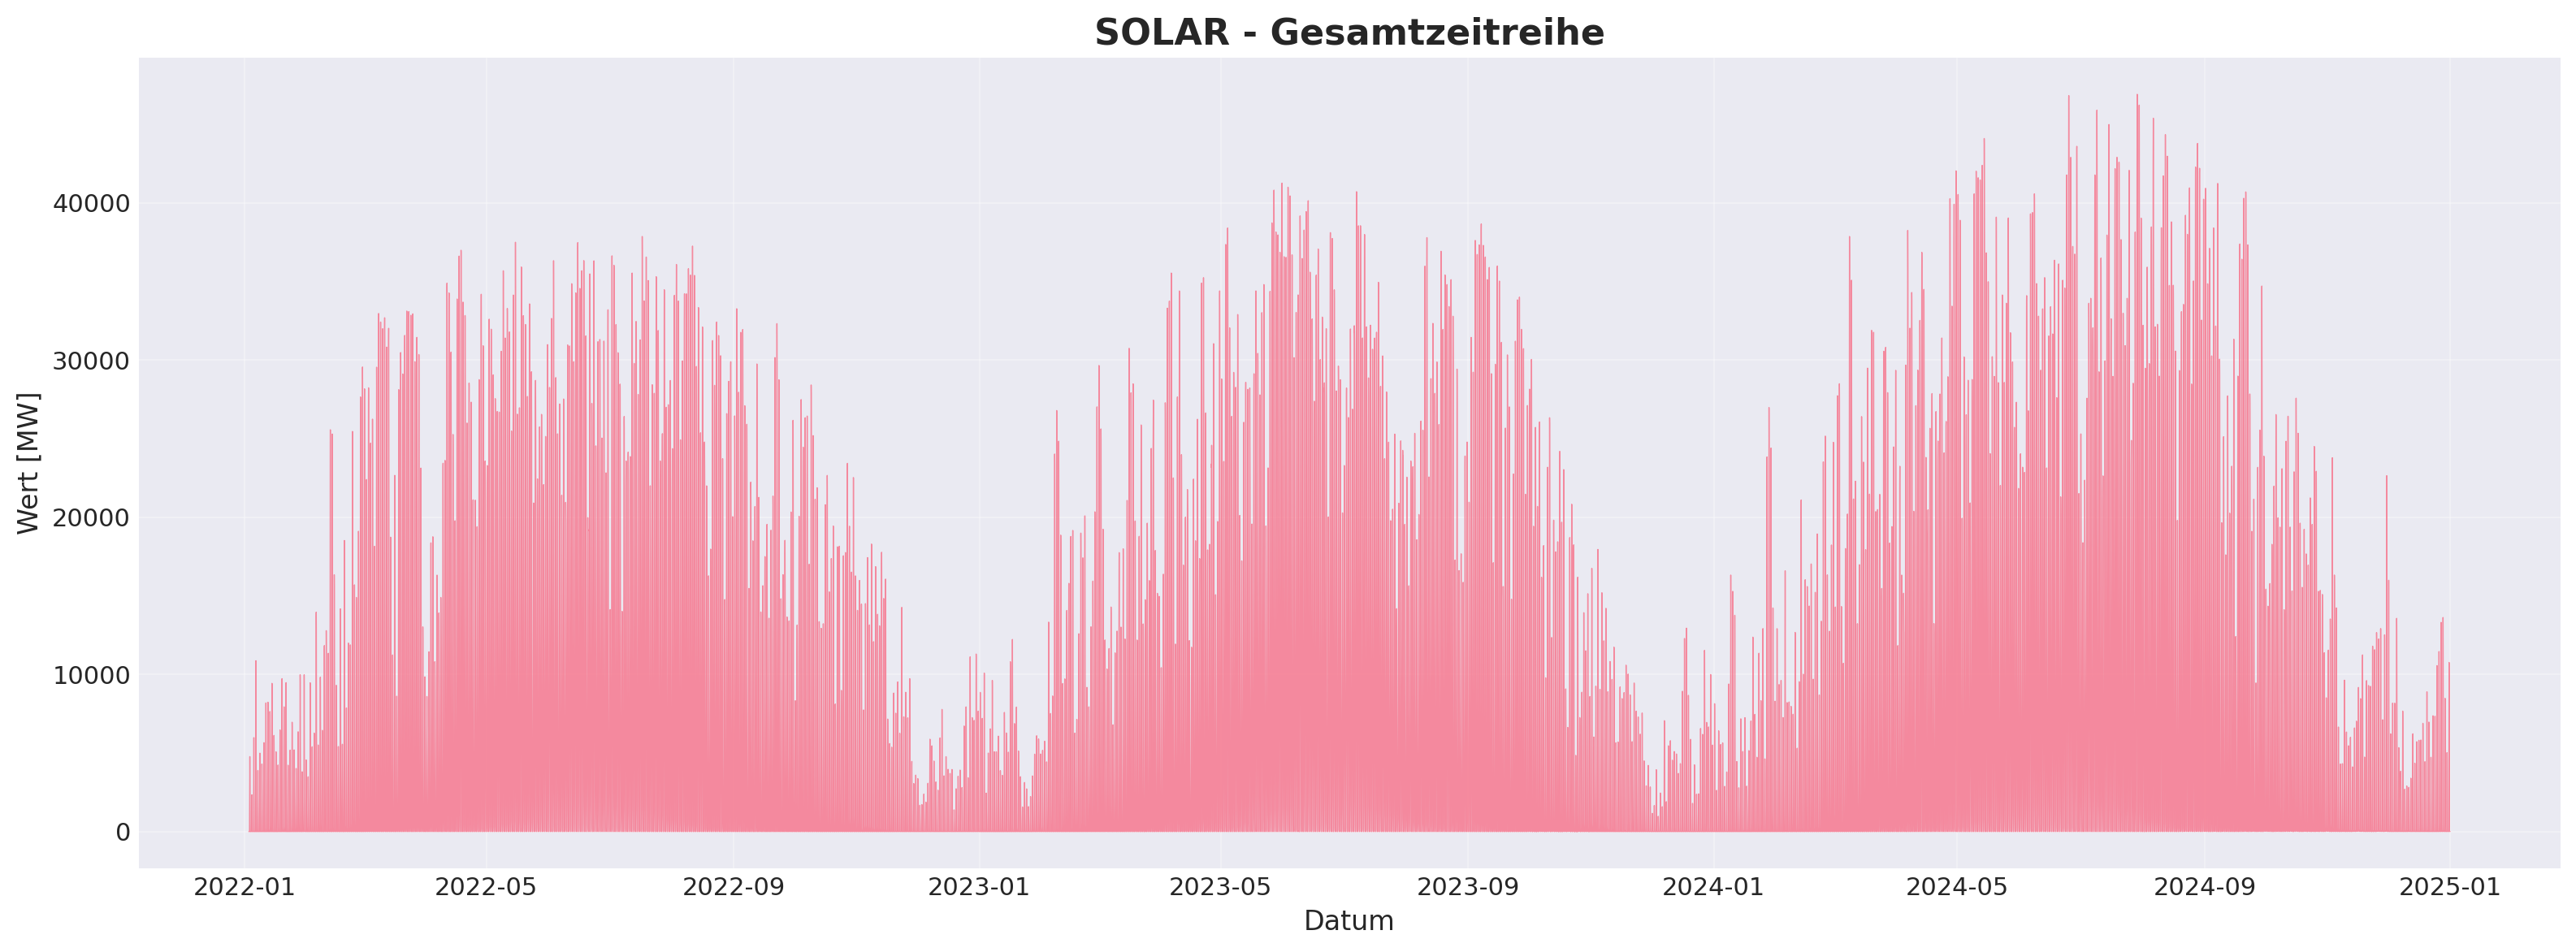

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df['timestamp'], df['value'], linewidth=0.5, alpha=0.8)
ax.set_title(f'{DATA_TYPE.upper()} - Gesamtzeitreihe', fontsize=16, fontweight='bold')
ax.set_xlabel('Datum', fontsize=12)
ax.set_ylabel('Wert [MW]', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Verteilungsanalyse

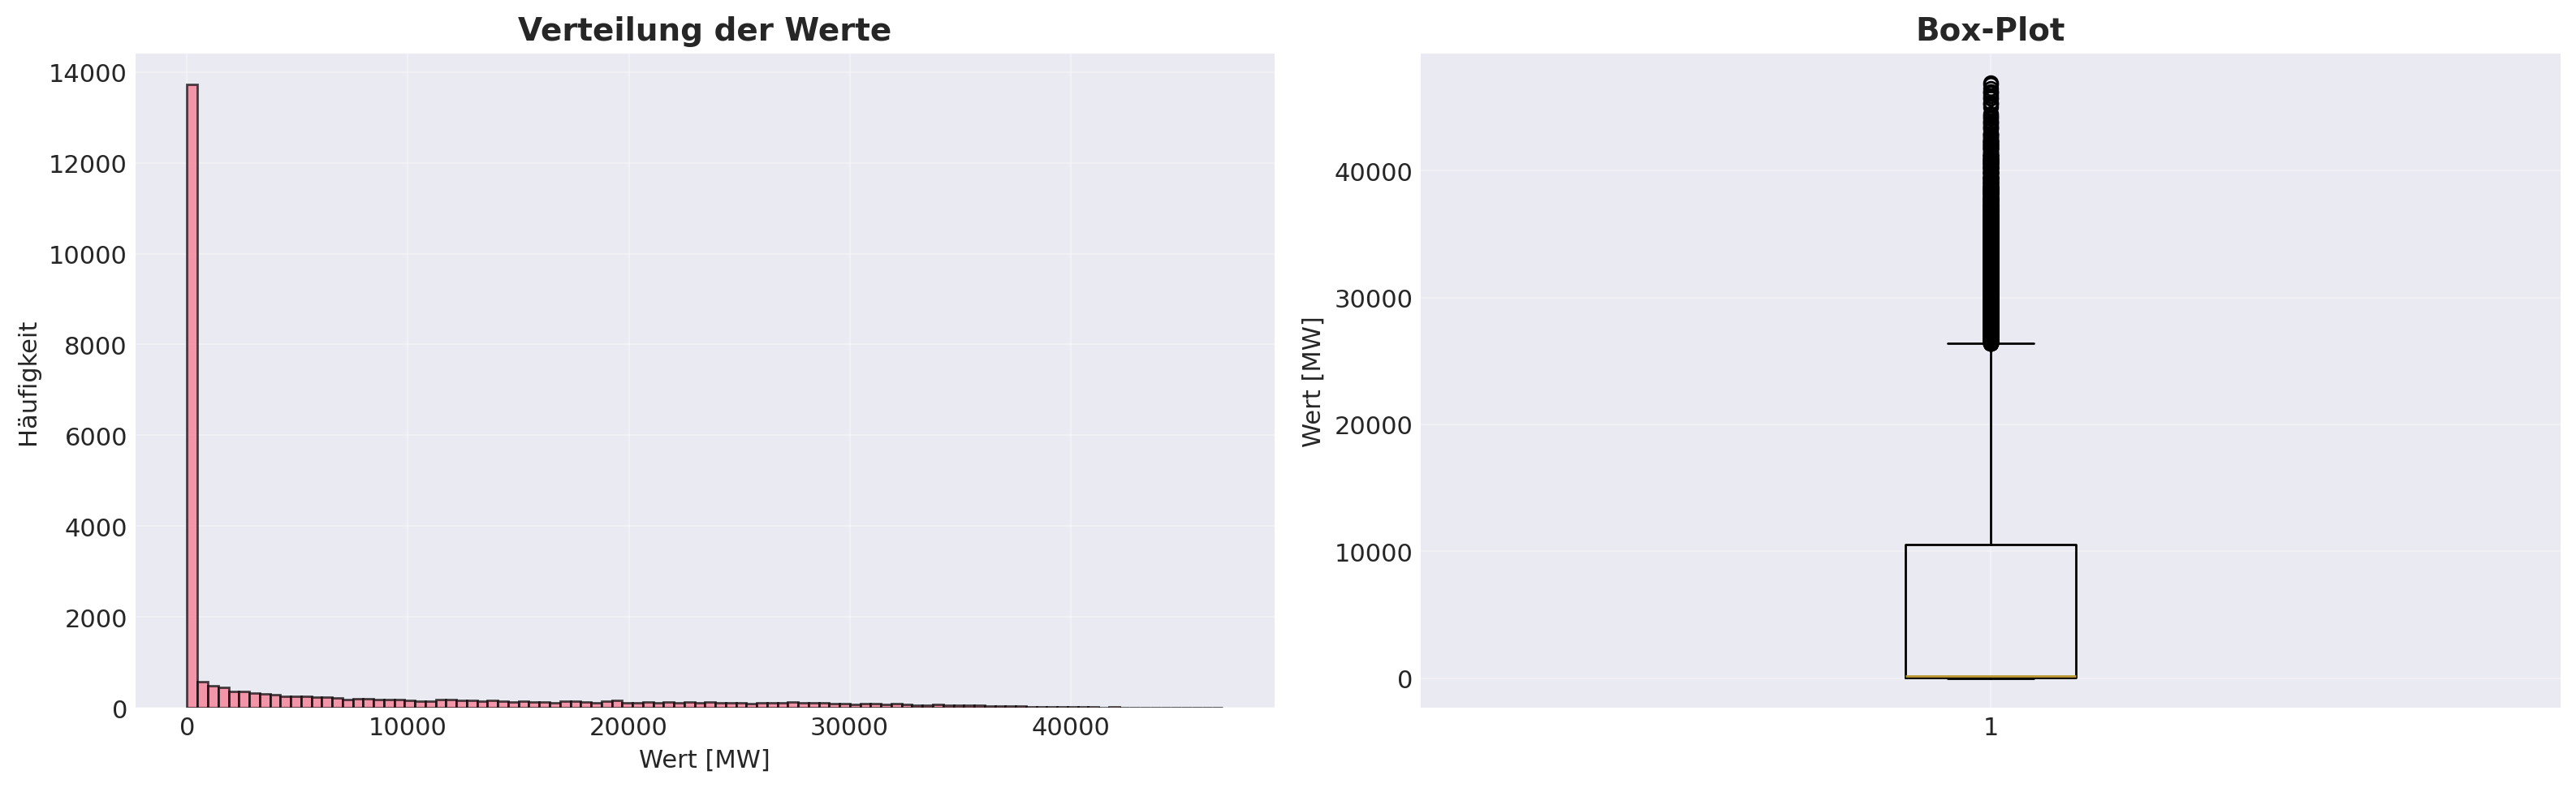


Statistische Kennzahlen:
count    26257.000000
mean      6640.635821
std      10189.126501
min          1.000000
25%          4.000000
50%        193.000000
75%      10554.500000
max      46897.500000
Name: value, dtype: float64


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogramm
axes[0].hist(df['value'].dropna(), bins=100, alpha=0.7, edgecolor='black')
axes[0].set_title('Verteilung der Werte', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Wert [MW]')
axes[0].set_ylabel('Häufigkeit')
axes[0].grid(True, alpha=0.3)

# Box-Plot
axes[1].boxplot(df['value'].dropna(), vert=True)
axes[1].set_title('Box-Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Wert [MW]')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik ausgeben
print("\nStatistische Kennzahlen:")
print(df['value'].describe())

## 5. Saisonalität analysieren

### 5.1 Monatliche Muster

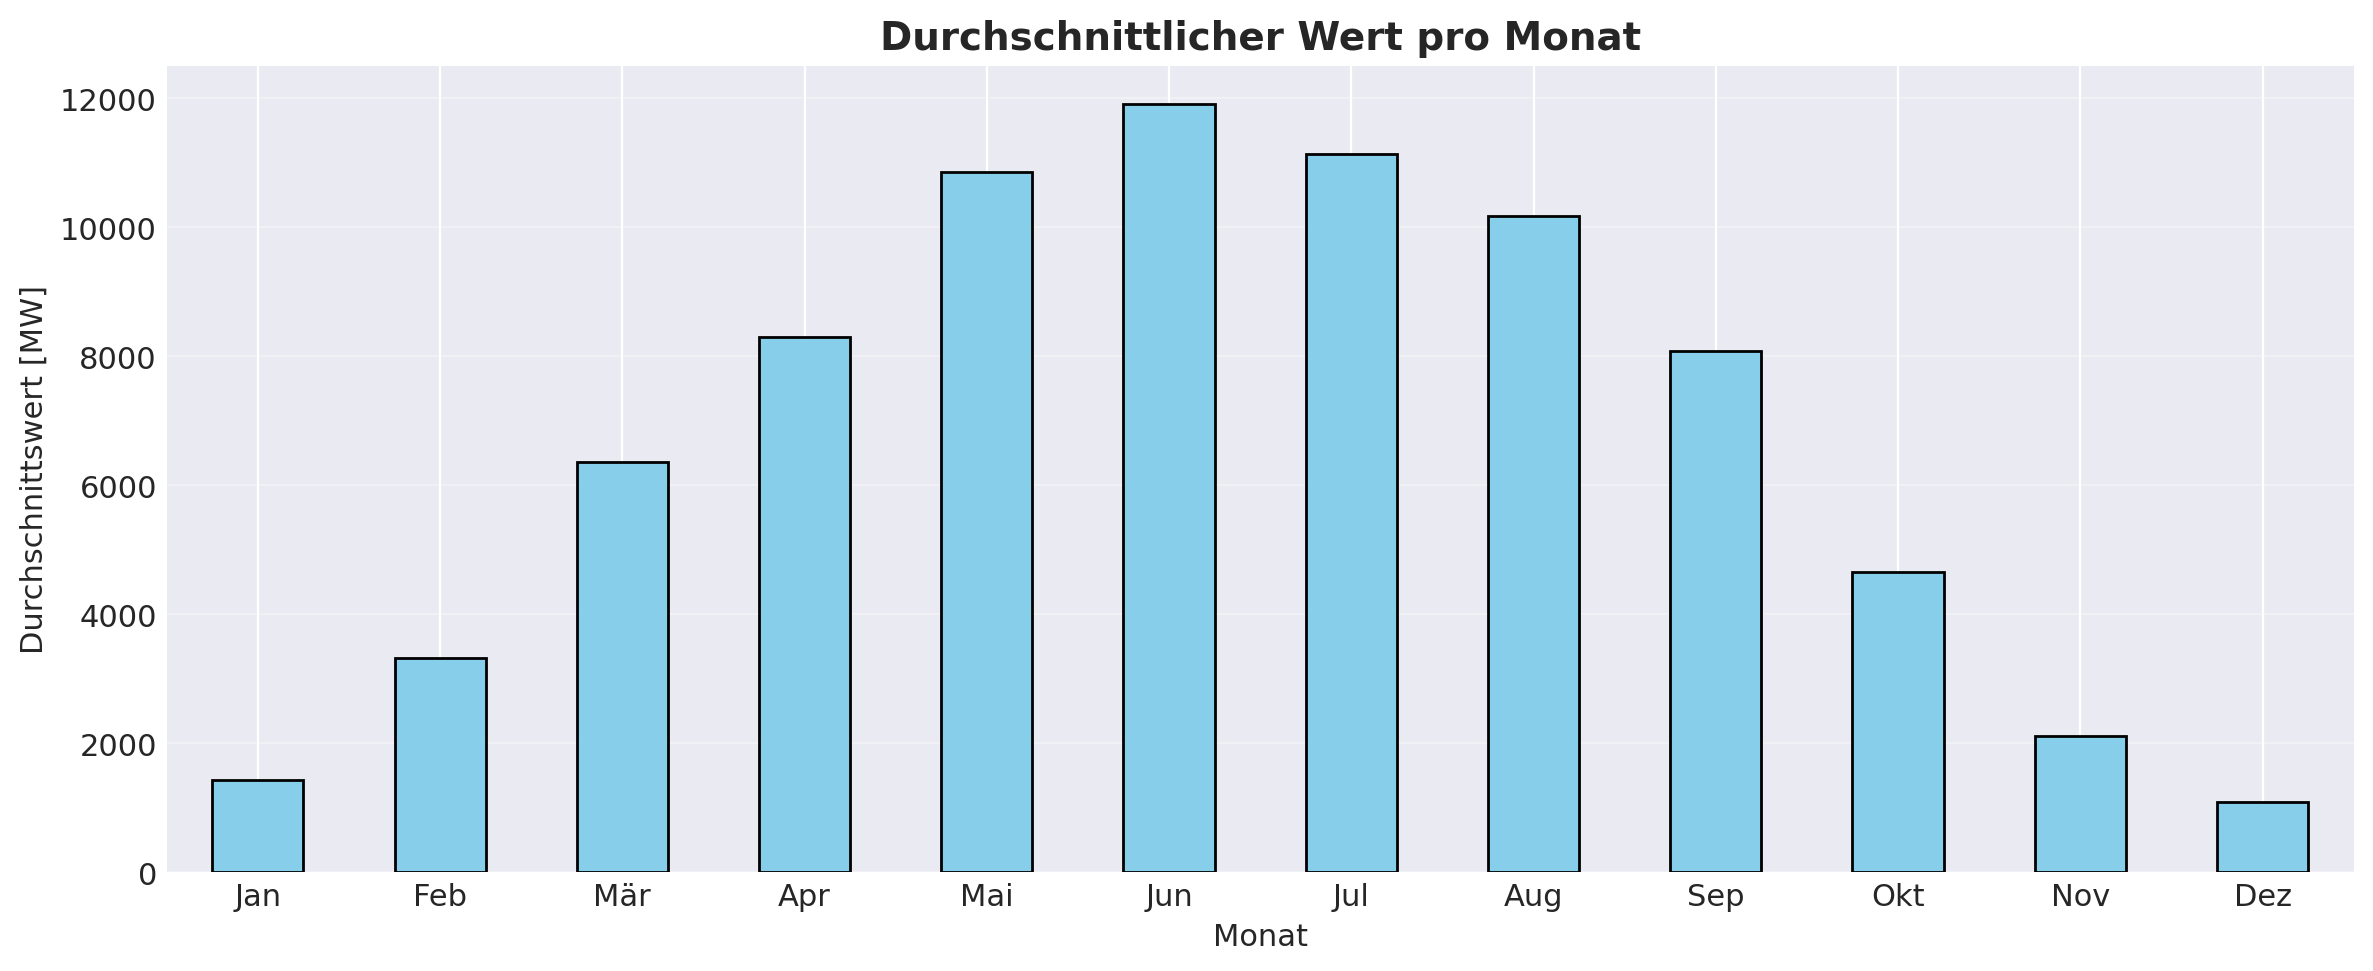

In [13]:
# Monat und Jahr extrahieren
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek  # 0=Montag, 6=Sonntag
df['dayofyear'] = df['timestamp'].dt.dayofyear

# Durchschnitt pro Monat
monthly_avg = df.groupby('month')['value'].mean()

fig, ax = plt.subplots(figsize=(12, 5))
monthly_avg.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Durchschnittlicher Wert pro Monat', fontsize=14, fontweight='bold')
ax.set_xlabel('Monat')
ax.set_ylabel('Durchschnittswert [MW]')
ax.set_xticklabels(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'], rotation=0)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 5.2 Wochentags-Muster

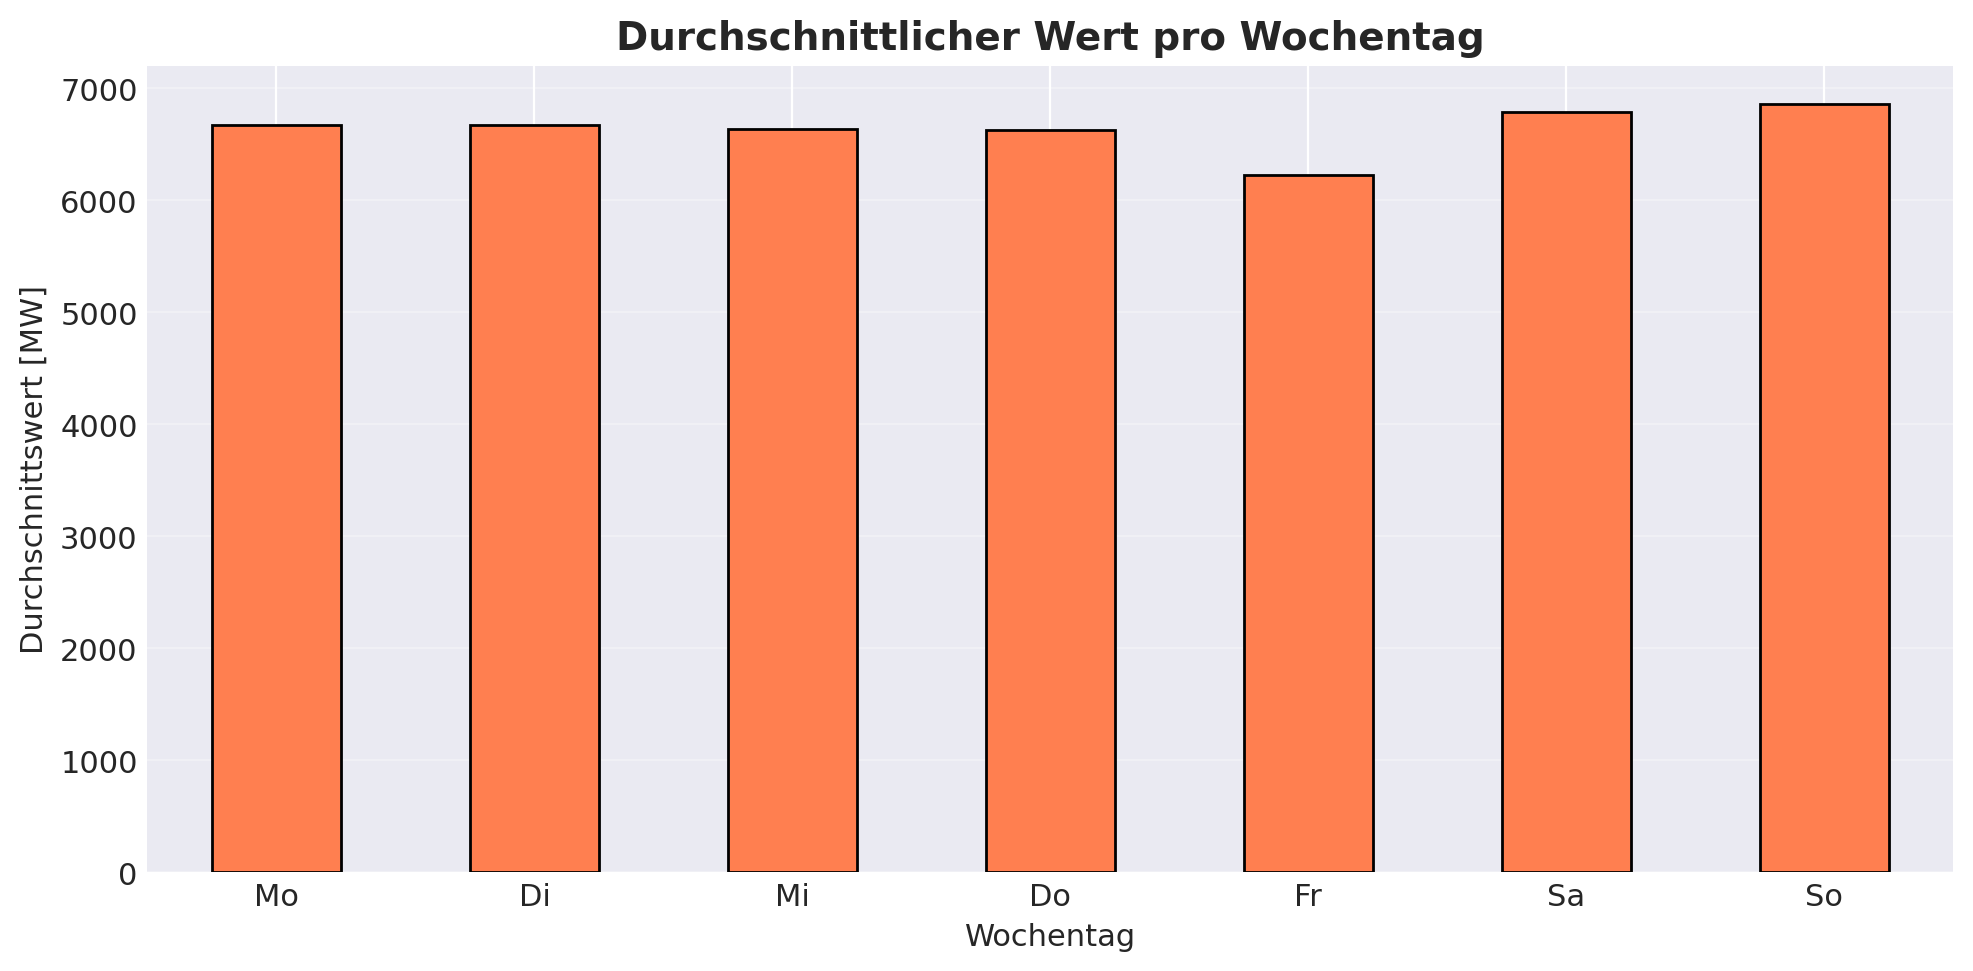

In [14]:
# Durchschnitt pro Wochentag
weekday_avg = df.groupby('dayofweek')['value'].mean()

fig, ax = plt.subplots(figsize=(10, 5))
weekday_avg.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_title('Durchschnittlicher Wert pro Wochentag', fontsize=14, fontweight='bold')
ax.set_xlabel('Wochentag')
ax.set_ylabel('Durchschnittswert [MW]')
ax.set_xticklabels(['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'], rotation=0)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 5.3 Tages-Muster (Stundenprofil)

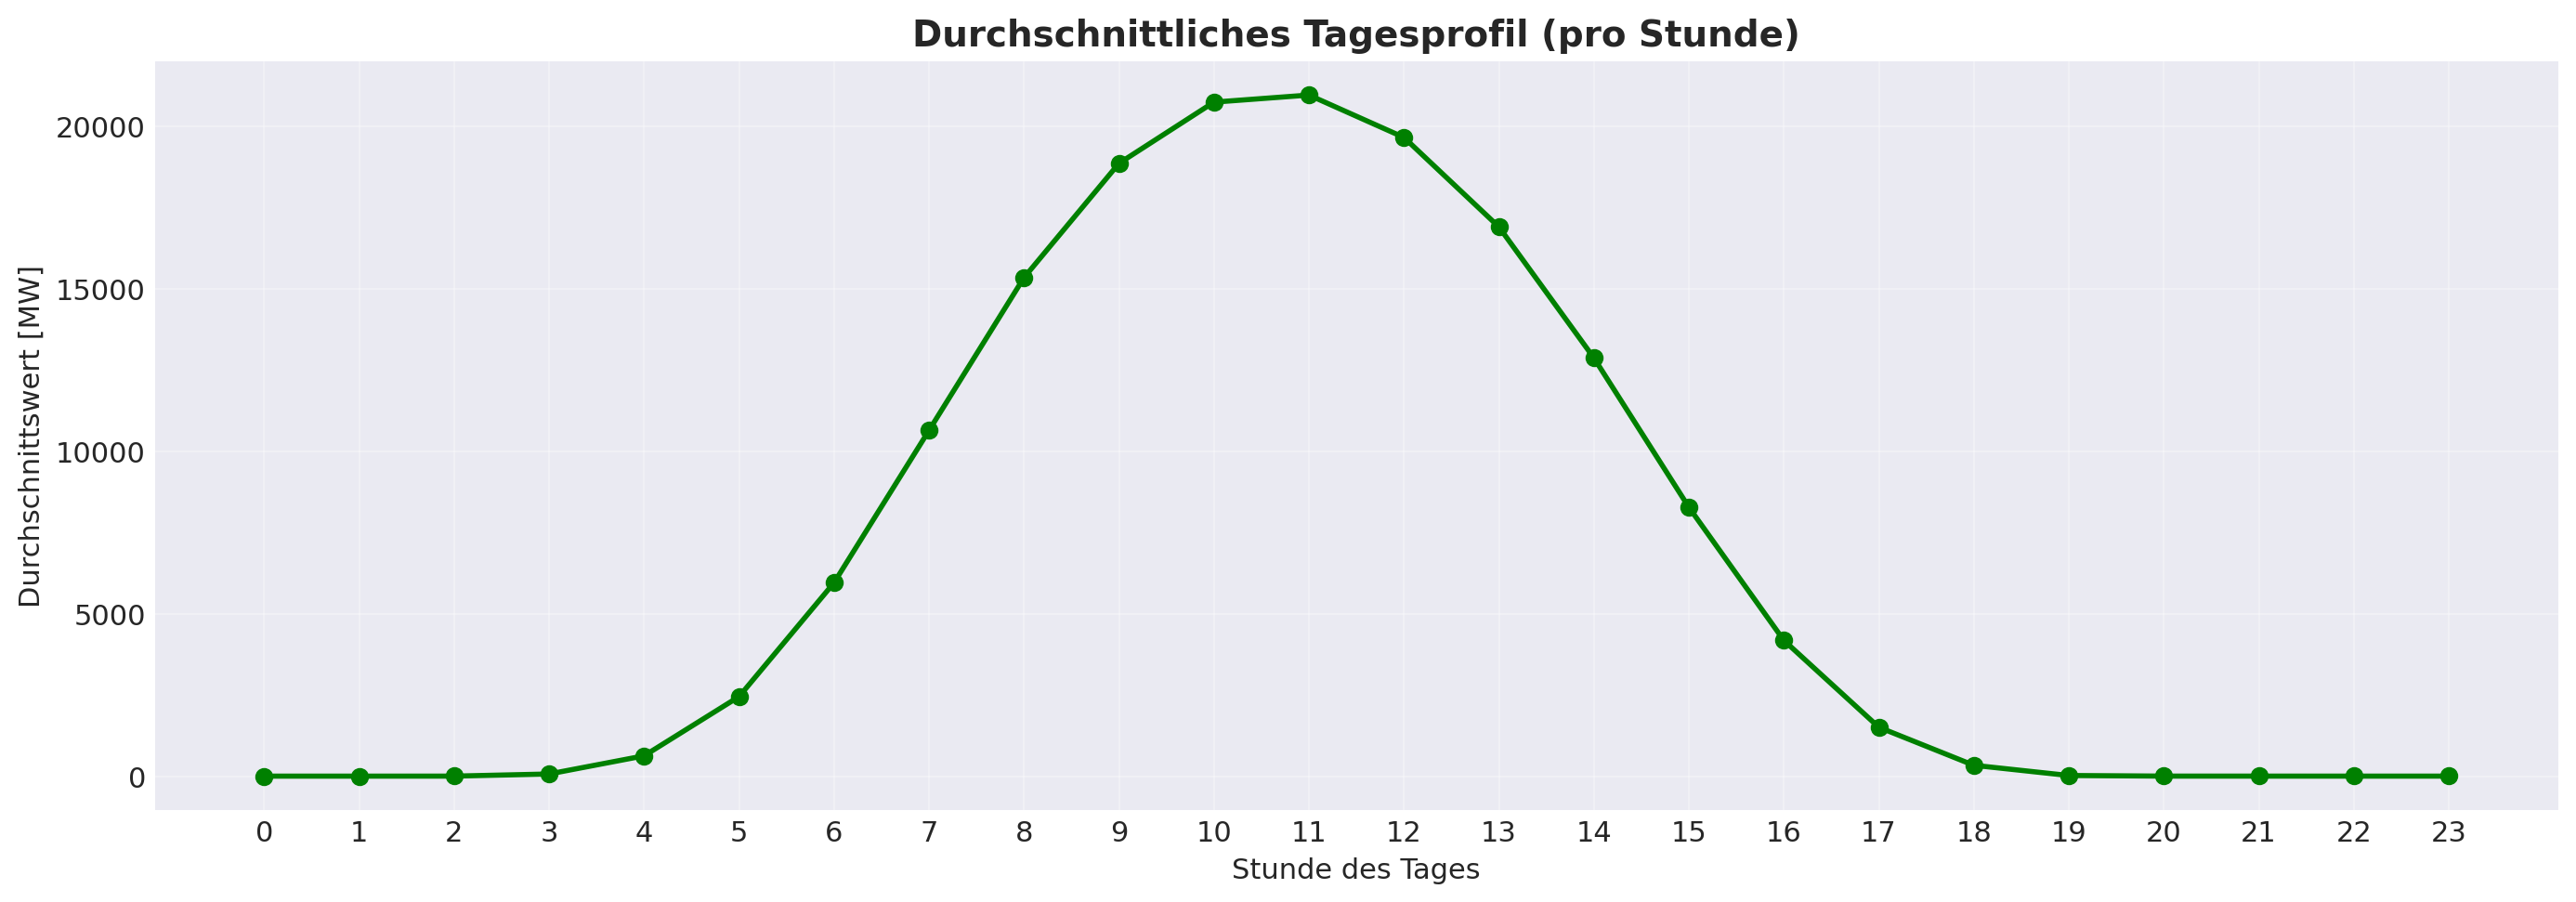

In [15]:
if RESOLUTION == 'hour':
    # Durchschnitt pro Stunde
    hourly_avg = df.groupby('hour')['value'].mean()
    
    fig, ax = plt.subplots(figsize=(14, 5))
    hourly_avg.plot(ax=ax, marker='o', linewidth=2, markersize=6, color='green')
    ax.set_title('Durchschnittliches Tagesprofil (pro Stunde)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Stunde des Tages')
    ax.set_ylabel('Durchschnittswert [MW]')
    ax.set_xticks(range(24))
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Stundenprofil nur für stündliche Auflösung verfügbar")

### 5.4 Jahresverlauf

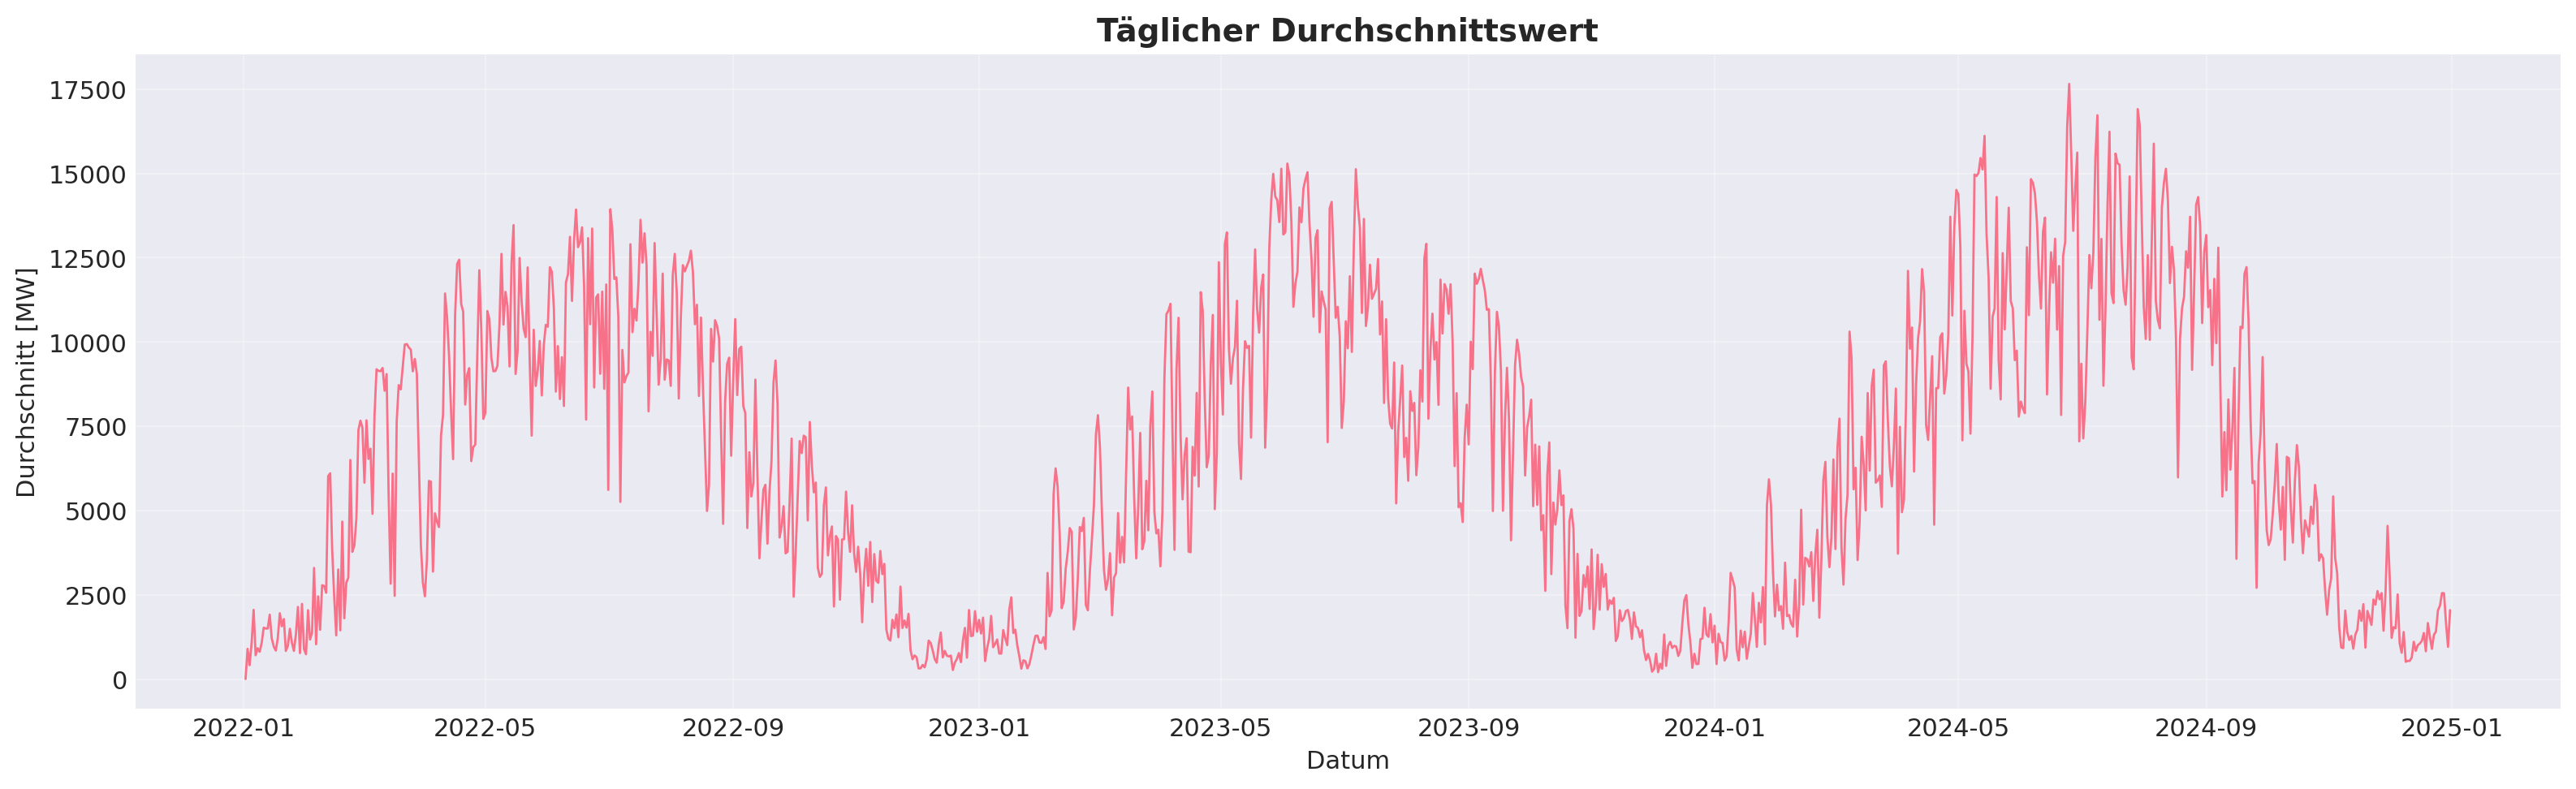

In [16]:
# Tagesdurchschnitt
daily_avg = df.groupby(df['timestamp'].dt.date)['value'].mean()

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(daily_avg.index, daily_avg.values, linewidth=1)
ax.set_title('Täglicher Durchschnittswert', fontsize=14, fontweight='bold')
ax.set_xlabel('Datum')
ax.set_ylabel('Durchschnitt [MW]')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### ⚠️ 5.5 Verbesserte Saisonalitäts-Analyse

**Problem mit den obigen Analysen (5.1 und 5.2):**

Die einfachen Durchschnittswerte sind **irreführend** für Solar-Energie, weil:
- **Nachtwerte (0 MW)** werden mitgemittelt
- Im **Winter** gibt es mehr Nachtstunden → niedrigerer Durchschnitt
- Im **Sommer** gibt es weniger Nachtstunden → höherer Durchschnitt
- Das erklärt, warum **Mai niedriger** als **November** erscheint (obwohl physikalisch falsch!)

**Lösung:** Wir analysieren nur Tagesstunden oder verwenden bessere Metriken.

#### 5.5.1 Monatliche Saisonalität - Nur Tagesstunden (6:00-20:00)

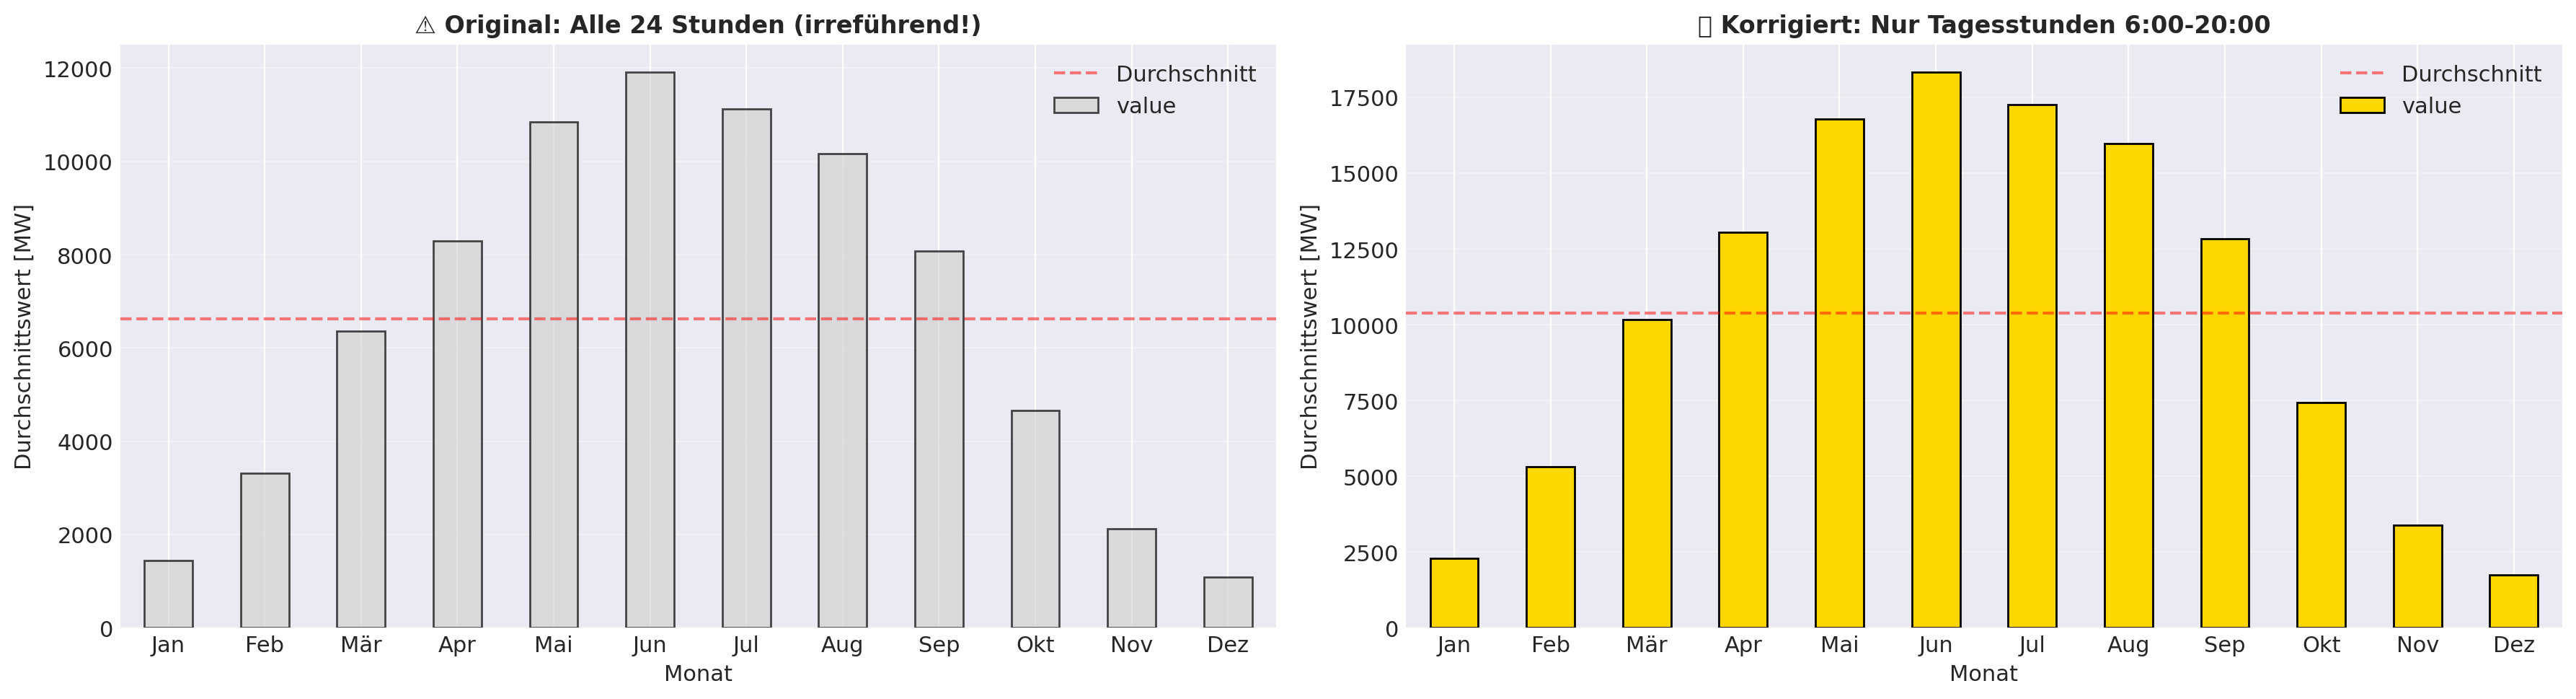

🌞 Jetzt macht es Sinn!
   → Sommer (Mai-Aug): 16094 MW
   → Winter (Nov-Feb): 3181 MW
   → Verhältnis Sommer/Winter: 5.06x


In [17]:
if RESOLUTION == 'hour':
    # Filter: Nur Tagesstunden (6:00 bis 20:00 Uhr)
    df_daylight = df[(df['hour'] >= 6) & (df['hour'] <= 20)].copy()
    
    # Durchschnitt pro Monat (nur Tagesstunden)
    monthly_daylight_avg = df_daylight.groupby('month')['value'].mean()
    
    # Vergleich: Original vs. Tagesstunden
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    # Original (mit Nachtstunden)
    monthly_avg.plot(kind='bar', ax=axes[0], color='lightgray', edgecolor='black', alpha=0.7)
    axes[0].set_title('⚠️ Original: Alle 24 Stunden (irreführend!)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Monat')
    axes[0].set_ylabel('Durchschnittswert [MW]')
    axes[0].set_xticklabels(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 
                             'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'], rotation=0)
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].axhline(monthly_avg.mean(), color='red', linestyle='--', alpha=0.5, label='Durchschnitt')
    axes[0].legend()
    
    # Korrigiert (nur Tagesstunden)
    monthly_daylight_avg.plot(kind='bar', ax=axes[1], color='gold', edgecolor='black')
    axes[1].set_title('✅ Korrigiert: Nur Tagesstunden 6:00-20:00', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Monat')
    axes[1].set_ylabel('Durchschnittswert [MW]')
    axes[1].set_xticklabels(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 
                             'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'], rotation=0)
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].axhline(monthly_daylight_avg.mean(), color='red', linestyle='--', alpha=0.5, label='Durchschnitt')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("🌞 Jetzt macht es Sinn!")
    print(f"   → Sommer (Mai-Aug): {monthly_daylight_avg[5:9].mean():.0f} MW")
    print(f"   → Winter (Nov-Feb): {monthly_daylight_avg[[11,12,1,2]].mean():.0f} MW")
    print(f"   → Verhältnis Sommer/Winter: {monthly_daylight_avg[5:9].mean() / monthly_daylight_avg[[11,12,1,2]].mean():.2f}x")
else:
    print("Diese Analyse benötigt stündliche Daten")

#### 5.5.2 Peak Solar: Maximale Tagesproduktion pro Monat

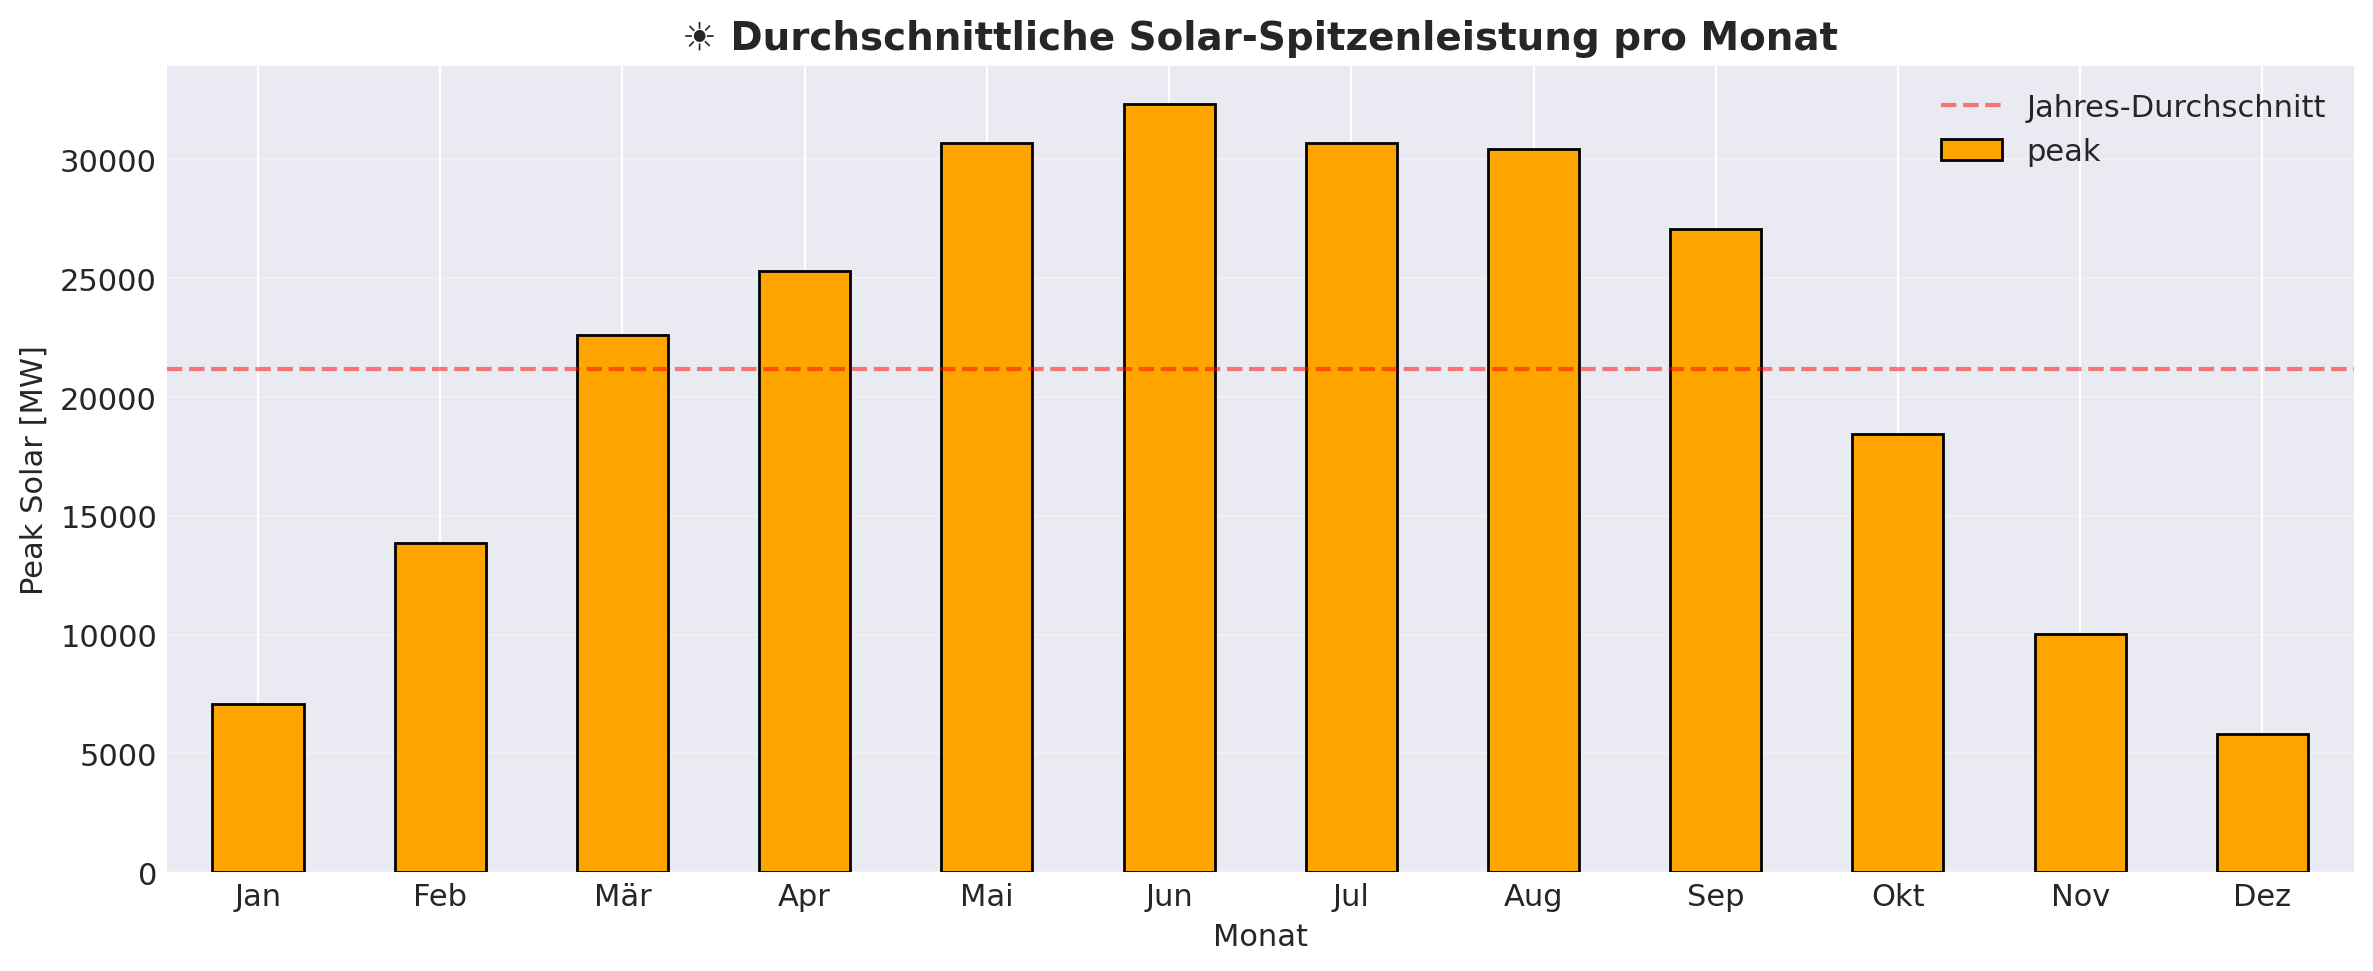


📊 Peak Solar Analyse:
   Höchster Monat: 6 (32333 MW)
   Niedrigster Monat: 12 (5830 MW)
   Verhältnis Max/Min: 5.55x


In [18]:
if RESOLUTION == 'hour':
    # Maximale Produktion pro Tag
    df['date'] = df['timestamp'].dt.date
    daily_peak = df.groupby('date')['value'].max()
    
    # Monatlicher Durchschnitt der Tagesspitzen
    daily_peak_df = pd.DataFrame({'peak': daily_peak})
    daily_peak_df['month'] = pd.to_datetime(daily_peak_df.index).month
    monthly_peak_avg = daily_peak_df.groupby('month')['peak'].mean()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    monthly_peak_avg.plot(kind='bar', ax=ax, color='orange', edgecolor='black')
    ax.set_title('☀️ Durchschnittliche Solar-Spitzenleistung pro Monat', fontsize=14, fontweight='bold')
    ax.set_xlabel('Monat')
    ax.set_ylabel('Peak Solar [MW]')
    ax.set_xticklabels(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'], rotation=0)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(monthly_peak_avg.mean(), color='red', linestyle='--', alpha=0.5, label='Jahres-Durchschnitt')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Peak Solar Analyse:")
    print(f"   Höchster Monat: {monthly_peak_avg.idxmax()} ({monthly_peak_avg.max():.0f} MW)")
    print(f"   Niedrigster Monat: {monthly_peak_avg.idxmin()} ({monthly_peak_avg.min():.0f} MW)")
    print(f"   Verhältnis Max/Min: {monthly_peak_avg.max() / monthly_peak_avg.min():.2f}x")
else:
    print("Diese Analyse benötigt stündliche Daten")

#### 5.5.3 Tägliche Gesamtproduktion (Energieertrag)

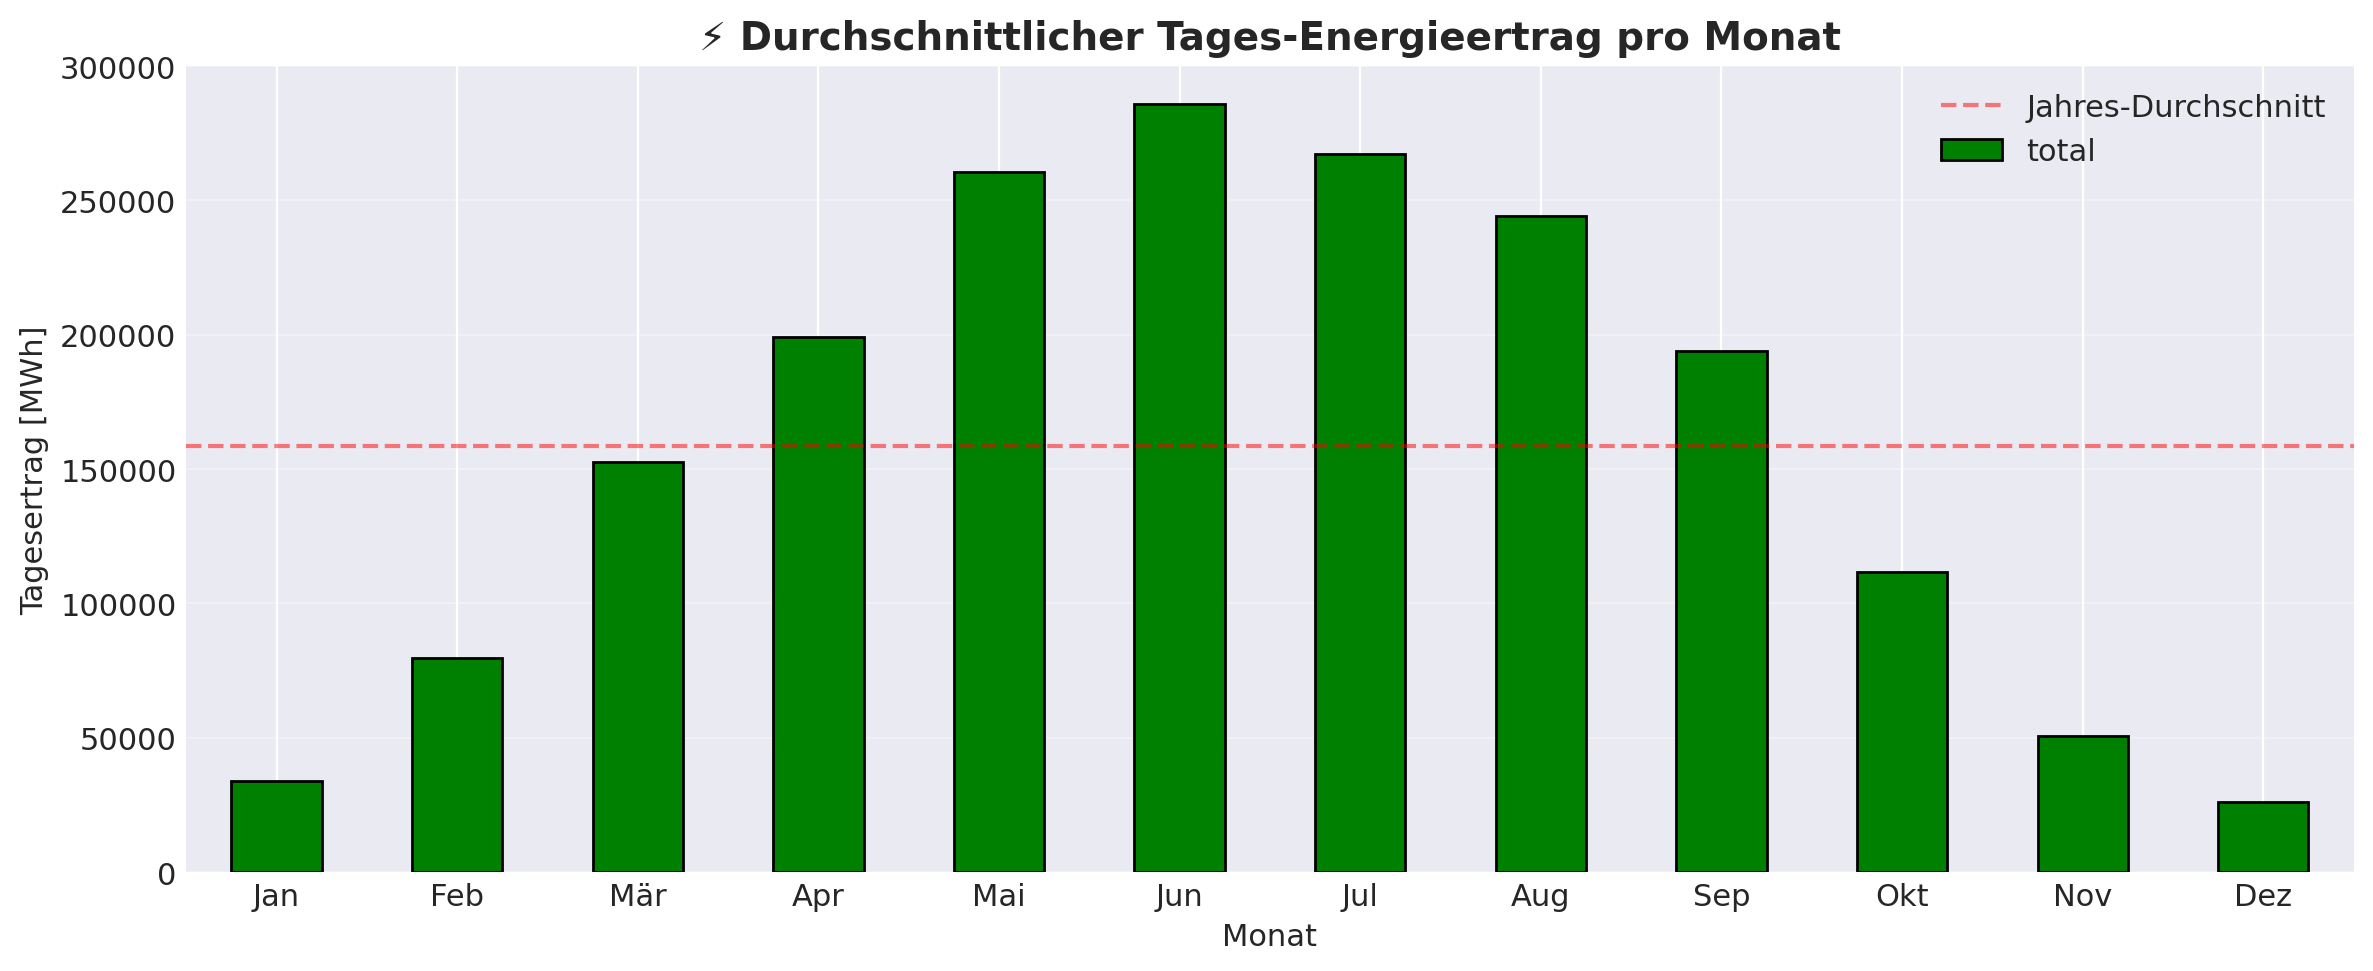


⚡ Energieertrag Analyse:
   Bester Monat: 6 (285882 MWh/Tag)
   Schlechtester Monat: 12 (26219 MWh/Tag)
   Verhältnis: 10.90x mehr Energie im Sommer


In [19]:
if RESOLUTION == 'hour':
    # Tägliche Gesamtproduktion (Summe über 24h)
    daily_total = df.groupby('date')['value'].sum()
    
    # Monatlicher Durchschnitt
    daily_total_df = pd.DataFrame({'total': daily_total})
    daily_total_df['month'] = pd.to_datetime(daily_total_df.index).month
    monthly_total_avg = daily_total_df.groupby('month')['total'].mean()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    monthly_total_avg.plot(kind='bar', ax=ax, color='green', edgecolor='black')
    ax.set_title('⚡ Durchschnittlicher Tages-Energieertrag pro Monat', fontsize=14, fontweight='bold')
    ax.set_xlabel('Monat')
    ax.set_ylabel('Tagesertrag [MWh]')
    ax.set_xticklabels(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'], rotation=0)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(monthly_total_avg.mean(), color='red', linestyle='--', alpha=0.5, label='Jahres-Durchschnitt')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n⚡ Energieertrag Analyse:")
    print(f"   Bester Monat: {monthly_total_avg.idxmax()} ({monthly_total_avg.max():.0f} MWh/Tag)")
    print(f"   Schlechtester Monat: {monthly_total_avg.idxmin()} ({monthly_total_avg.min():.0f} MWh/Tag)")
    print(f"   Verhältnis: {monthly_total_avg.max() / monthly_total_avg.min():.2f}x mehr Energie im Sommer")
else:
    print("Diese Analyse benötigt stündliche Daten")

#### 5.5.4 Wochentags-Analyse - Korrigiert (nur Tagesstunden)

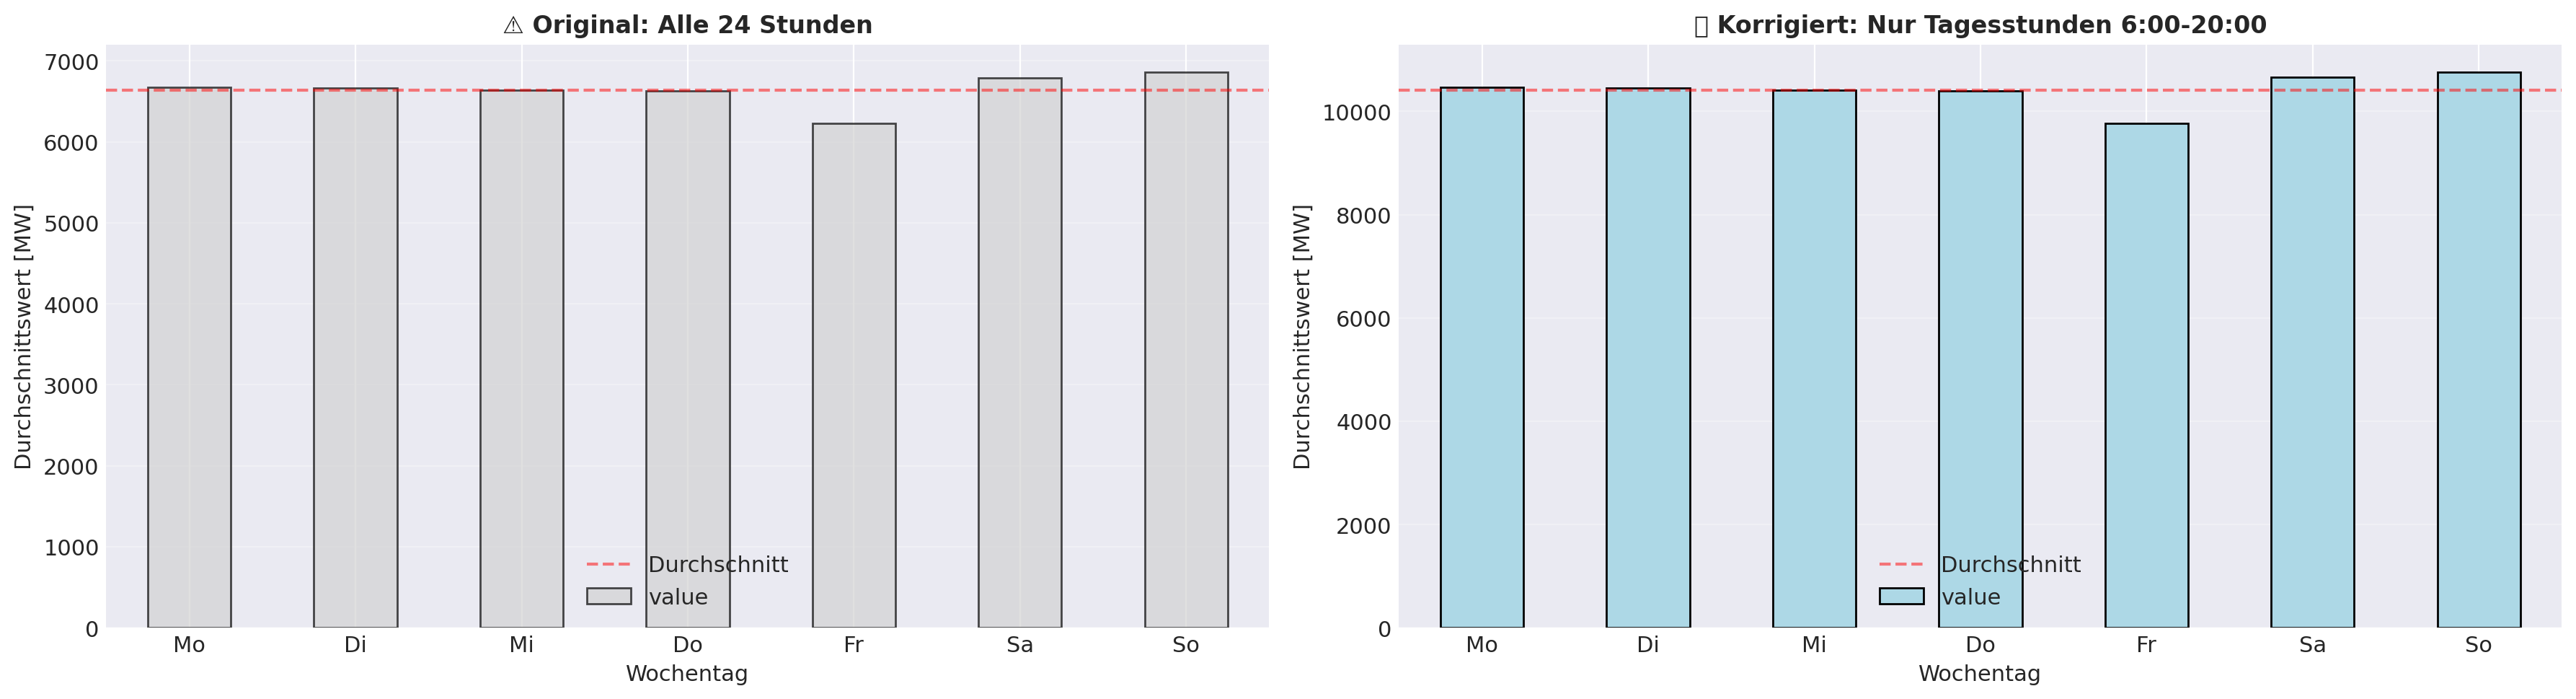


📊 Wochentags-Variabilität:
   Standardabweichung (alle 24h): 201 MW
   Standardabweichung (Tagesstunden): 318 MW
   → Bei Solar gibt es 3.0% Variabilität zwischen Wochentagen

   ⚠️ Interpretation: Es gibt wochentagsspezifische Muster


In [20]:
if RESOLUTION == 'hour':
    # Wochentags-Durchschnitt nur für Tagesstunden
    weekday_daylight_avg = df_daylight.groupby('dayofweek')['value'].mean()
    
    # Vergleich: Original vs. Korrigiert
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    # Original (mit Nachtstunden)
    weekday_avg.plot(kind='bar', ax=axes[0], color='lightgray', edgecolor='black', alpha=0.7)
    axes[0].set_title('⚠️ Original: Alle 24 Stunden', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Wochentag')
    axes[0].set_ylabel('Durchschnittswert [MW]')
    axes[0].set_xticklabels(['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'], rotation=0)
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].axhline(weekday_avg.mean(), color='red', linestyle='--', alpha=0.5, label='Durchschnitt')
    axes[0].legend()
    
    # Korrigiert (nur Tagesstunden)
    weekday_daylight_avg.plot(kind='bar', ax=axes[1], color='lightblue', edgecolor='black')
    axes[1].set_title('✅ Korrigiert: Nur Tagesstunden 6:00-20:00', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Wochentag')
    axes[1].set_ylabel('Durchschnittswert [MW]')
    axes[1].set_xticklabels(['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'], rotation=0)
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].axhline(weekday_daylight_avg.mean(), color='red', linestyle='--', alpha=0.5, label='Durchschnitt')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Standardabweichung berechnen
    std_all = weekday_avg.std()
    std_daylight = weekday_daylight_avg.std()
    
    print("\n📊 Wochentags-Variabilität:")
    print(f"   Standardabweichung (alle 24h): {std_all:.0f} MW")
    print(f"   Standardabweichung (Tagesstunden): {std_daylight:.0f} MW")
    print(f"   → Bei Solar gibt es {std_daylight/weekday_daylight_avg.mean()*100:.1f}% Variabilität zwischen Wochentagen")
    
    if std_daylight < 100:  # Geringe Variabilität
        print("\n   ✅ Interpretation: Wochentag hat KEINEN signifikanten Einfluss auf Solar-Produktion")
        print("      (Die Sonne scheint unabhängig vom Wochentag!)")
    else:
        print("\n   ⚠️ Interpretation: Es gibt wochentagsspezifische Muster")
else:
    print("Diese Analyse benötigt stündliche Daten")

### 📌 Key Takeaways aus der korrigierten Analyse:

1. **Monatliche Saisonalität:**
   - ✅ Sommer (Mai-August) hat **höhere** Solar-Produktion als Winter
   - ✅ Peak im Juni/Juli (längste Tage)
   - ✅ Minimum im Dezember/Januar (kürzeste Tage)

2. **Wochentags-Muster:**
   - ✅ Fast **keine Variabilität** zwischen Wochentagen
   - ✅ Die Sonne kennt kein Wochenende!
   - ⚠️ Kleine Unterschiede könnten durch Wetterkorrelationen entstehen

3. **Wichtige Lektion:**
   - Bei Zeitreihen mit **starken Nullwerten** (Nacht bei Solar) sind einfache Durchschnitte irreführend
   - Immer die **physikalische Plausibilität** prüfen
   - Bessere Metriken: Peak-Werte, Tages-Summen, oder Filter auf relevante Zeitfenster

## 6. Autokorrelation (ACF) und Partielle Autokorrelation (PACF)

Wichtig für:
- Erkennung von Abhängigkeiten
- ARIMA-Parameter-Auswahl

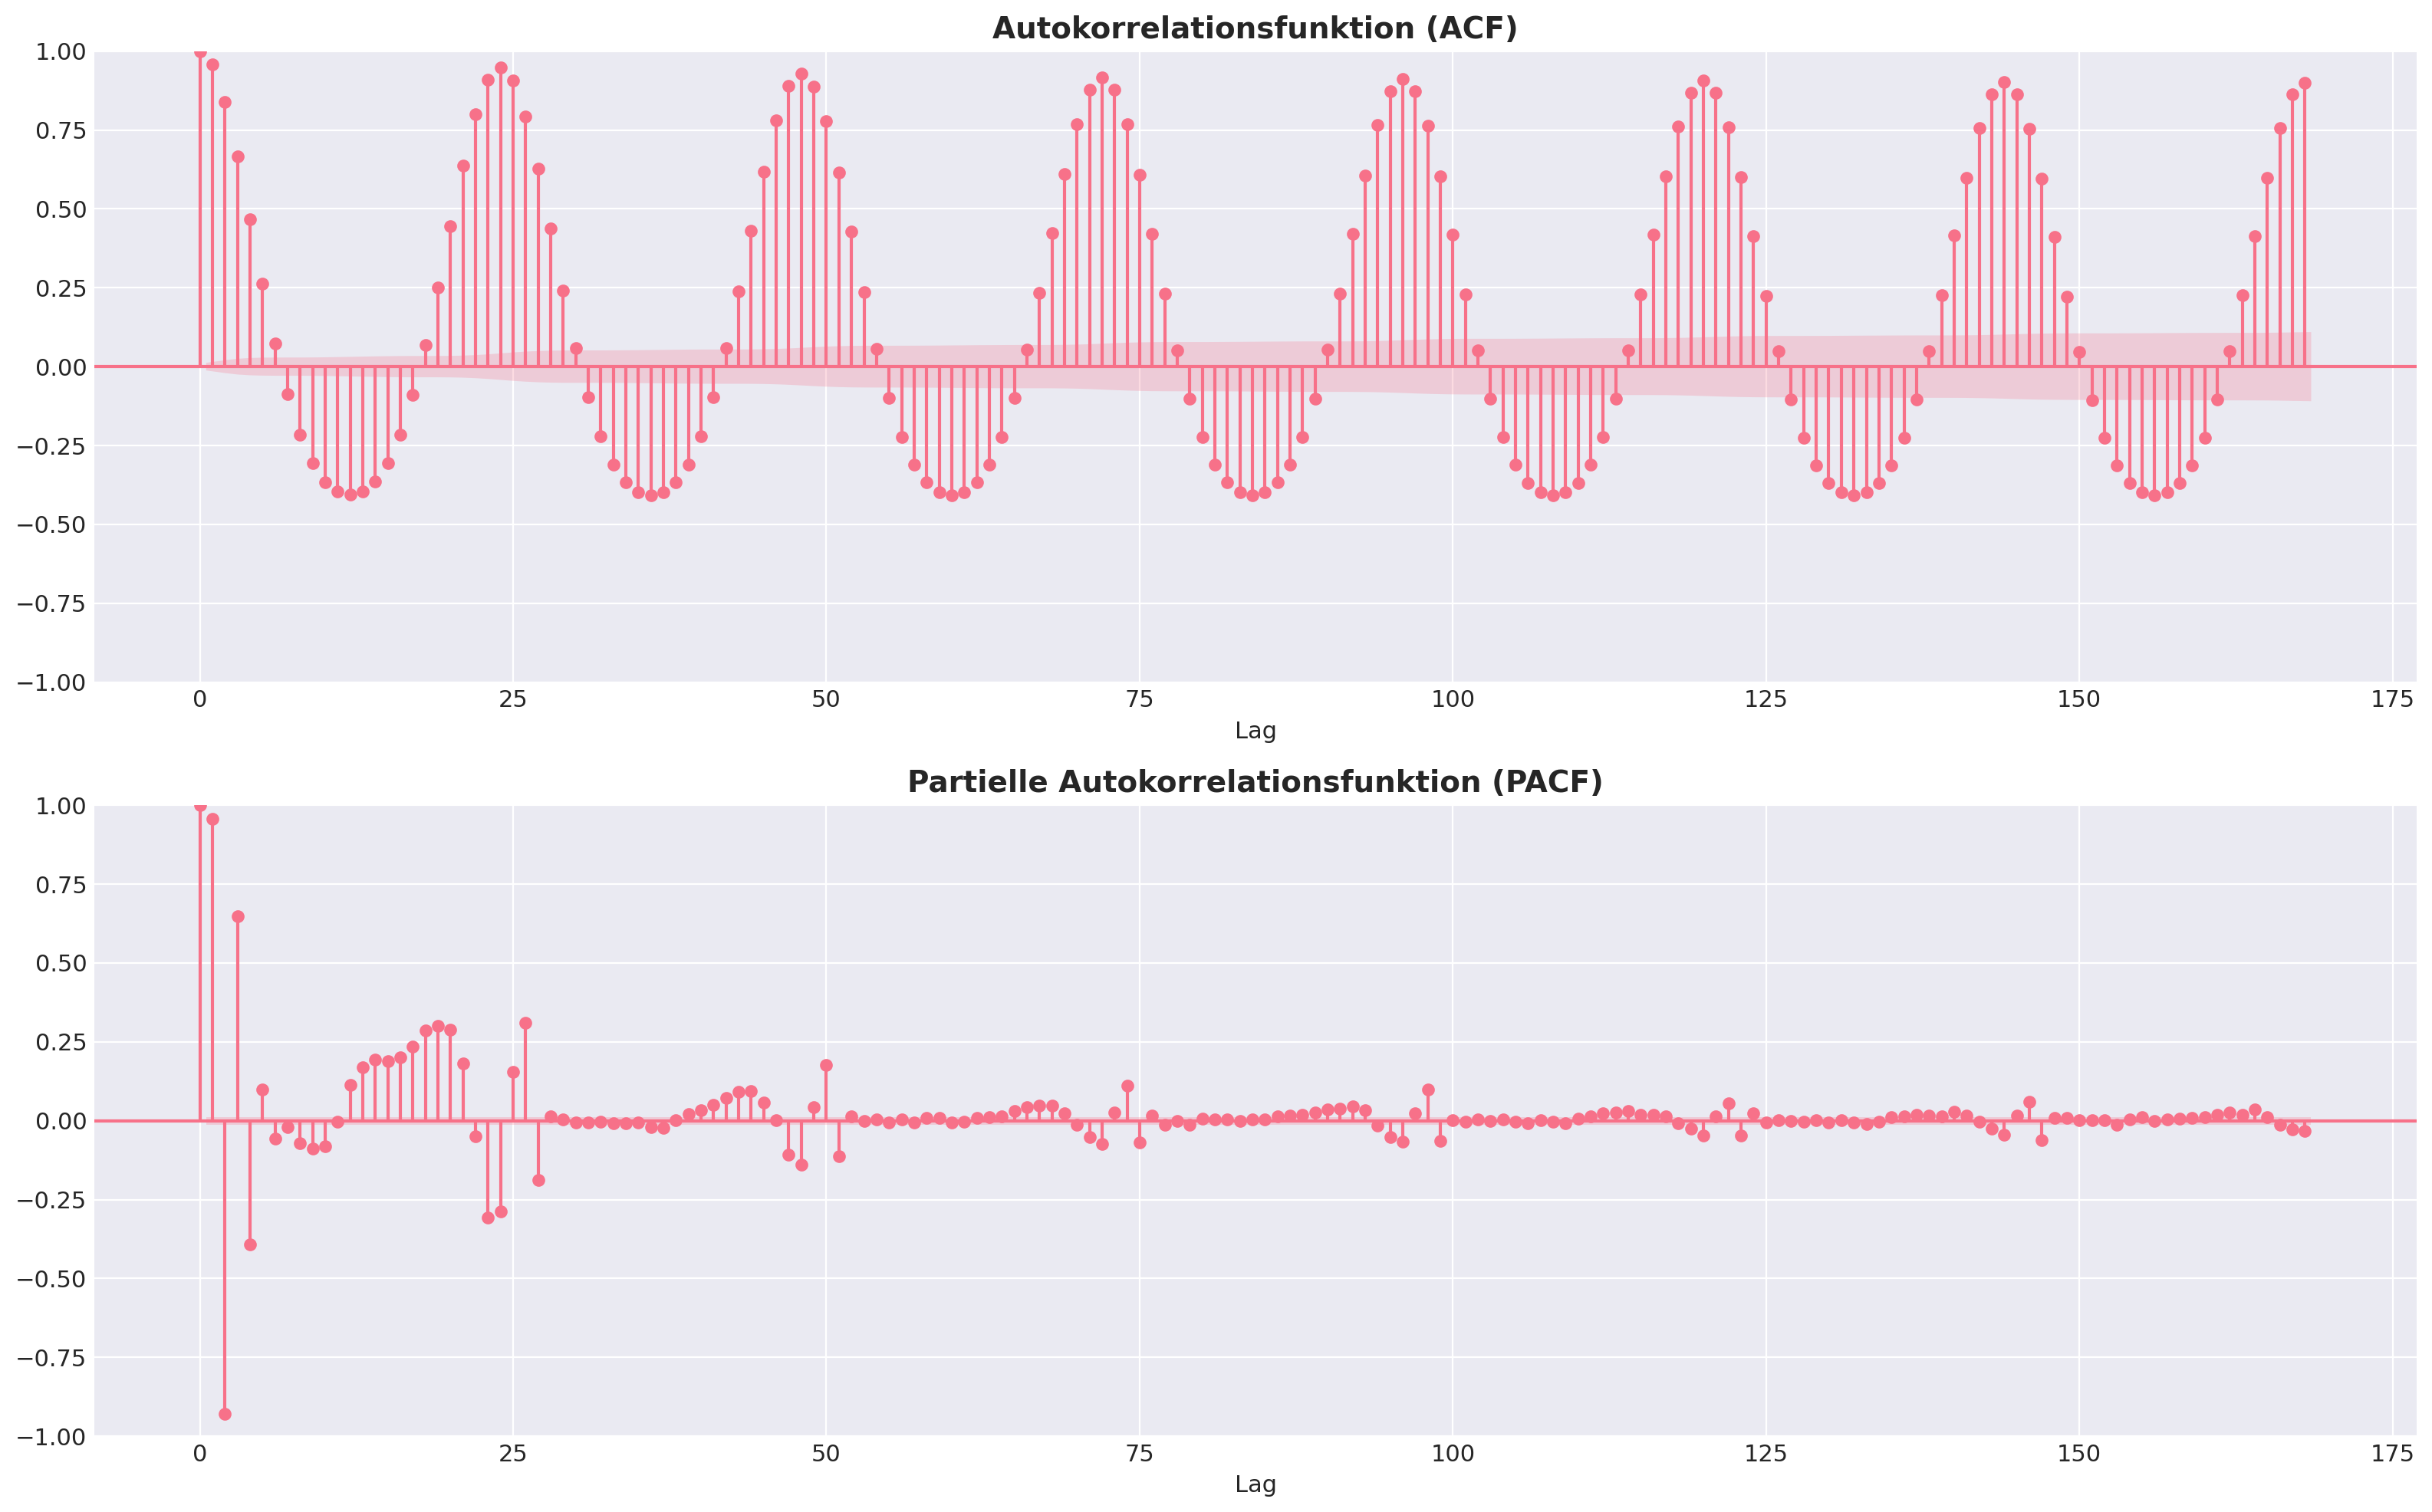

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Nur nicht-fehlende Werte
values_clean = df['value'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ACF
plot_acf(values_clean, lags=168, ax=axes[0])  # 7 Tage für stündliche Daten
axes[0].set_title('Autokorrelationsfunktion (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag')

# PACF
plot_pacf(values_clean, lags=168, ax=axes[1])
axes[1].set_title('Partielle Autokorrelationsfunktion (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

## 7. Stationaritätstest

Augmented Dickey-Fuller Test:
- H0: Zeitreihe ist nicht-stationär
- H1: Zeitreihe ist stationär
- p-value < 0.05 → Zeitreihe ist stationär

In [22]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result_adf = adfuller(values_clean)

print("=" * 60)
print("STATIONARITÄTSTEST")
print("=" * 60)
print("\nAugmented Dickey-Fuller Test:")
print(f"  ADF Statistic: {result_adf[0]:.6f}")
print(f"  p-value: {result_adf[1]:.6f}")
print(f"  Critical Values:")
for key, value in result_adf[4].items():
    print(f"    {key}: {value:.3f}")

if result_adf[1] < 0.05:
    print("\n  ✅ Zeitreihe ist STATIONÄR (p < 0.05)")
else:
    print("\n  ⚠️  Zeitreihe ist NICHT-STATIONÄR (p >= 0.05)")
    print("      → Differenzierung könnte notwendig sein")

# KPSS Test (zusätzlich)
try:
    result_kpss = kpss(values_clean, regression='ct')
    print("\n\nKPSS Test (Trend-Stationarität):")
    print(f"  KPSS Statistic: {result_kpss[0]:.6f}")
    print(f"  p-value: {result_kpss[1]:.6f}")
    
    if result_kpss[1] > 0.05:
        print("\n  ✅ Zeitreihe ist TREND-STATIONÄR (p > 0.05)")
    else:
        print("\n  ⚠️  Zeitreihe ist NICHT TREND-STATIONÄR (p <= 0.05)")
except:
    print("\nKPSS Test konnte nicht durchgeführt werden")

print("\n" + "=" * 60)

STATIONARITÄTSTEST

Augmented Dickey-Fuller Test:
  ADF Statistic: -5.206327
  p-value: 0.000009
  Critical Values:
    1%: -3.431
    5%: -2.862
    10%: -2.567

  ✅ Zeitreihe ist STATIONÄR (p < 0.05)


KPSS Test (Trend-Stationarität):
  KPSS Statistic: 1.574584
  p-value: 0.010000

  ⚠️  Zeitreihe ist NICHT TREND-STATIONÄR (p <= 0.05)



/tmp/ipykernel_2504/2332959990.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(values_clean, regression='ct')


## 8. Zusammenfassung & Nächste Schritte

### Erkenntnisse aus der EDA:

**Bitte trage hier deine Beobachtungen ein:**

1. **Datenqualität:**
   - [ ] Fehlende Werte vorhanden? → Strategie festlegen
   - [ ] Ausreißer vorhanden? → Behandlung notwendig?
   - [ ] Zeitlücken? → Interpolation?

2. **Saisonalität:**
   - [ ] Tägliche Saisonalität erkennbar?
   - [ ] Wöchentliche Saisonalität?
   - [ ] Jährliche Saisonalität?

3. **Trend:**
   - [ ] Aufwärtstrend?
   - [ ] Abwärtstrend?
   - [ ] Kein Trend?

4. **Stationarität:**
   - [ ] Stationär?
   - [ ] Differenzierung notwendig?

### Nächste Schritte:

1. **Datenaufbereitung** → `02_data_preprocessing.ipynb`
   - Fehlende Werte behandeln
   - Ausreißer behandeln
   - Features engineering
   - Train/Test/Validation Split

2. **Baseline-Modelle** → `03_baseline_models.ipynb`
   - Naive Forecast
   - Seasonal Naive
   - Moving Average

3. **Statistische Modelle** → `04_statistical_models.ipynb`
   - SARIMA(X)
   - ETS

4. **Machine Learning** → `05_ml_tree_models.ipynb`
   - XGBoost, LightGBM, CatBoost

5. **Deep Learning** → `06_deep_learning_models.ipynb`
   - LSTM, GRU

6. **Advanced Models** → `07_advanced_models.ipynb`
   - TFT, N-BEATS

7. **Model Comparison** → `08_model_comparison.ipynb`

In [23]:
# Optional: Aufbereitete Daten speichern für weitere Notebooks
output_file = Path('../data/processed') / f'{DATA_TYPE}_{START_DATE}_{END_DATE}_initial.csv'
df.to_csv(output_file, index=False)
print(f"✅ Daten gespeichert: {output_file}")

✅ Daten gespeichert: ../data/processed/solar_2022-01-01_2024-12-31_initial.csv
